Author: Amiri Hayes \
Date Updated: 7/15/25 \
Title: ViewLLM

Starter code !

In [ ]:
# package installs if necessary
!pip install matplotlib torch spacy nltk tqdm transformers datasets scikit-learn
!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")

In [5]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
nltk.download('punkt_tab')
import os
import csv
import json
import requests
from dotenv import load_dotenv, find_dotenv
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from typing import Optional, Tuple, Callable
import matplotlib.patches as mpatches
from matplotlib.colors import PowerNorm, ListedColormap
from sklearn.linear_model import LinearRegression
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import PreTrainedTokenizerBase, PreTrainedModel
print("Imports completed successfully.")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\amkah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Imports completed successfully.


<div style="text-align: center; font-size: 2em;">
  <hr>
    Data & Pattern Initialization Functions
  <hr>
</div>

In [ ]:
# IMPORT THE PROGRAM DATABASE:

from programs import *

In [6]:
# GENERATE & VISUALIZE ATTENTION PATTERN SCORES FROM PROGRAMS

def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
    p = np.clip(p, 1e-12, 1.0)
    q = np.clip(q, 1e-12, 1.0)
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m)))

def score_prediction(torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, head_loc: Tuple[int, int], pattern: Callable, sentence_1: str, sentence_2: Optional[str] = None, distance="jsd", output=False):
    layer, head = head_loc
    tokens = torch_tokenizer(sentence_1, return_tensors="pt")

    if torch_model.config.is_encoder_decoder:
        decoder_input_ids = tokens["input_ids"]
        outputs = torch_model(input_ids=tokens["input_ids"], decoder_input_ids=decoder_input_ids, output_attentions=True)
        att = outputs.encoder_attentions[layer][0, head].detach().numpy()

    else:
        if sentence_2 and pattern.__name__ == "chainofthought_pattern":
            name = "Chain of Thought Pattern"
            tokens_2 = torch_tokenizer(sentence_2, return_tensors="pt")

            att = torch_model(**tokens_2, output_attentions=True).attentions[layer][0, head].detach().numpy()
            pred_att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()

            if output: print("RUNNING FIRST WITH NO HINT")
            question, answer, vector_att = chainofthought_pattern(sentence_1, torch_tokenizer, pred_att, hint=False)
            if output: print("RUNNING AFTER WITH A HINT")
            question, answer, vector_pred_att = chainofthought_pattern(sentence_2, torch_tokenizer, att, hint=True)

            att, pred_att = vector_att.copy(), vector_pred_att.copy()
        else:
            att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()
            if pattern.__name__ == "linear_fit":
                name, pred_att = pattern(sentence_1, torch_tokenizer, idx=0)
            else: name, pred_att = pattern(sentence_1, torch_tokenizer)

    if distance == "raw":
        score = np.abs(att - pred_att).sum()
    elif distance == "jsd":
        jensonshannon_distances = []
        for row_att, row_out in zip(att, pred_att):
            jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
        score = np.mean(jensonshannon_distances)

    if pattern.__name__ == "chainofthought_pattern":
        score = np.sqrt(js_divergence(att, pred_att))

    if output == "cot":
        colors = "inferno"
        fig, axes = plt.subplots(1, 2, figsize=(12, 9))
        axes[0].plot(att, color=plt.get_cmap(colors)(0.6))
        axes[0].set_title("Actual Head Attention")
        axes[1].plot(pred_att, color=plt.get_cmap(colors)(0.9))
        axes[1].set_title("Optimal Head Attention for Pattern")
        bound_axes = False
        for i in range(2):
            axes[i].set_xlabel("Token Index")
            axes[i].set_ylabel("Attention Weight")
            axes[i].grid(True)
            if bound_axes:
                axes[i].set_ylim(0, 1)
                axes[i].set_xlim(0, len(att) - 1)
        underlined_name_unicode = "".join([char + '\u0332' for char in name])
        question_chart = question.replace(".", ".\n")
        plt.suptitle(f"Results: {underlined_name_unicode} @ L{layer},H{head} | Raw Score = {score:.2f}\n\nQuestion: \"{question_chart}\n\nAnswer: \"{answer}\"", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    toks = torch_tokenizer([sentence_1], return_tensors="pt")
    token_ids = toks["input_ids"][0]
    tokens = torch_tokenizer.convert_ids_to_tokens(token_ids)

    if output == True:
        colors="Greens"
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        im1 = axes[0].imshow(att, cmap=colors, aspect='auto')
        axes[0].set_title("Actual Head Attention")
        fig.colorbar(im1, ax=axes[0])
        im2 = axes[1].imshow(pred_att, cmap=colors, aspect='auto')
        axes[1].set_title("Optimal Head Attention for Pattern")
        fig.colorbar(im2, ax=axes[1])
        for i in range(2):
            axes[i].set_xticks(range(len(tokens)))
            axes[i].set_yticks(range(len(tokens)))
            axes[i].set_xticklabels(tokens, rotation=90)
            axes[i].set_yticklabels(tokens)
        underlined_name_unicode = "".join([char + '\u0332' for char in name])
        plt.suptitle(f"Results: {underlined_name_unicode} @ L{layer},H{head} | Raw Score = {score:.2f}\n\nSentence: \"{sentence_1}\"", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif output == "optimal":
        colors = "Oranges"
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        im2 = ax.imshow(pred_att, cmap=colors, aspect='auto')
        ax.set_axis_off()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif output == "actual":
        colors = "Reds"
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        im2 = ax.imshow(att, cmap=colors, aspect='auto')
        ax.set_title("Example Head Attention for Pattern")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return score

In [7]:
# DOWNLOAD ADDITIONAL TEXT DATA (1):

file = 'data/small_text.csv'
df = pd.read_csv(file)

sentences = []
for paragraph in df['text']:
    sentences.extend(sent_tokenize(paragraph))

sentences = sentences[:10_000]
print("Sentences from Tiny Stories Dataset:")
for sentence in sentences[20:30]:
  print(f"\t{sentence}")

df_json = pd.read_json('data/generic_sentences.json')
generic_sentences = df_json[0].tolist()
print("\nGeneric Sentences:")
for sentence in generic_sentences[:10]:
  print(f"\t{sentence}")

Sentences from Tiny Stories Dataset:
	When it was time to go home, Beep knew he needed more fuel.
	He went to the fuel place and got more healthy fuel.
	Now, Beep was ready to go fast and play again the next day.
	And Beep lived happily ever after.
	One day, a little fish named Fin was swimming near the shore.
	He saw a big crab and wanted to be friends.
	"Hi, I am Fin.
	Do you want to play?"
	asked the little fish.
	The crab looked at Fin and said, "No, I don't want to play.

Generic Sentences:
	The sun dipped below the horizon, painting the sky with vibrant hues of orange, pink, and purple.
	She wondered, 'Will he ever understand the complexities of this intricate problem?'
	Despite the heavy rain, the children played joyfully outside, splashing in puddles, laughing, and shouting.
	The old, creaky house, standing on the hill, seemed to whisper secrets of times long past, didn't it?
	Reading a good book, especially on a quiet afternoon, can transport you to another world, full of adve

In [ ]:
# DOWNLOAD ADDITIONAL TEXT DATA (2):

math_data = pd.read_json('data/math_problems_results.jsonl', lines=True)

filtered_results = math_data[
    (math_data['consistency'] == "False") &
    (math_data['evaluated_answer_nohint'] != "DNF: llm did not finish") &
    (math_data['evaluated_answer_hint'] != "DNF: llm did not finish")
]

answers_nohint = filtered_results['answer_nohint'].tolist()
answers_hint = filtered_results['answer_hint'].tolist()
prefix = "system\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nuser\n\n"

prompts = []
for s1, s2 in zip(answers_nohint, answers_hint):
    if s1.startswith(prefix): s1 = s1[len(prefix):]
    if s2.startswith(prefix): s2 = s2[len(prefix):]

    i_suffix_s1 = s1.find("assistant")
    if i_suffix_s1 != -1: s1 = s1[:i_suffix_s1].strip()

    i_suffix_s2 = s2.find("assistant")
    if i_suffix_s2 != -1: s2 = s2[:i_suffix_s2].strip()

    if s1 and s2: prompts.append((s1, s2))

print(len(prompts), "relevant prompts loaded from math problems dataset.")

32 relevant prompts loaded from math problems dataset.


<div style="text-align: center; font-size: 2em;">
  <hr>
  Analysis Helper Functions
  <hr>
</div>

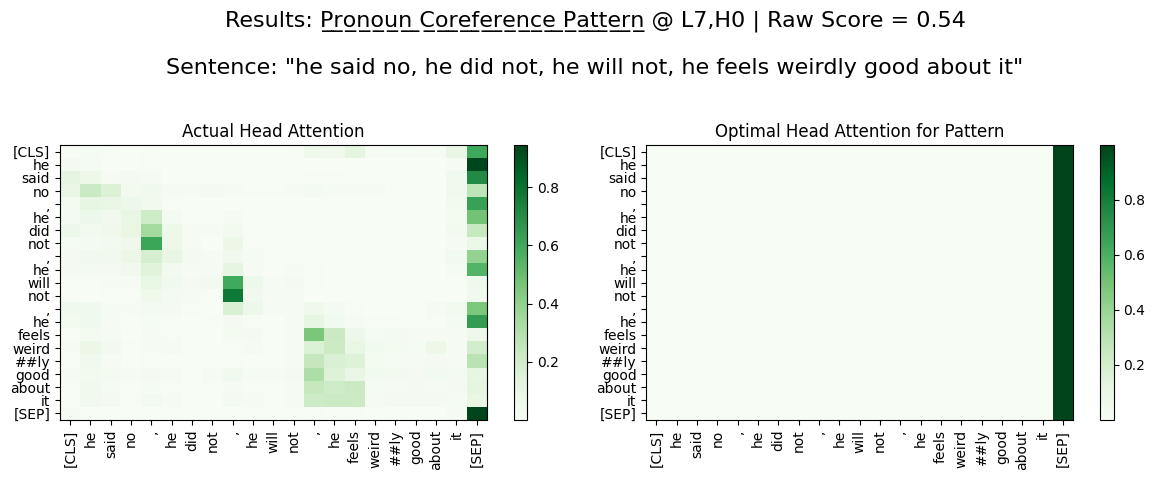

np.float64(0.539458781592816)

In [247]:
# ANALYZE PATTERN AT LAYER AND HEAD

sentence = "The quick brown fox jumps over the lazy dog."
sentence = "Hi. How are you? I'm fine! Thanks. Bye, see you tomorrow."
sentence = "I like apples and I like bananas. I like apples more though."

models = ["bert-base-uncased", "openai-community/gpt2", "google-t5/t5-small", "Meta-Llama-3.1-8B-Instruct"]

i = 0
name = models[i]

if i in [0,1,2]: # small models ( <400M Params )
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModel.from_pretrained(name, output_attentions=True)
    model.eval()

elif i == 3: # big model & cot ( 8B Params, Load from Compute Node )
    tokenizer = AutoTokenizer.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
    model = AutoModelForCausalLM.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
    model.eval()

    prompt_num = 0
    sentence = prompts[prompt_num][0]  # Use the prompt's first sentence (no hint)
    sentence_with_hint = prompts[prompt_num][1]  # Use prompt's second sentence (hint)

def pronoun_coreference(sentence: str, tokenizer) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))

    words = tokenizer.convert_ids_to_tokens(toks.input_ids[0])
    pronouns = ["he", "she", "him", "her", "they", "them", "it", "its", "his", "hers"]

    for i, tok in enumerate(words):
        if tok in pronouns:
            # Simple heuristic: link to the closest preceding noun
            for j in range(i - 1, 0, -1): # Iterate backwards, excluding [CLS] and current
                # Check for capitalized words as a proxy for nouns (simplification)
                if words[j].isalpha() and words[j][0].isupper():
                  out[i, j] = 0.7  # Attend to the noun
                  out[i, i] = 0.3 # Attend to self
                  break  # Link to closest preceding noun

    for row in range(len_seq): # Ensure no row is all zeros
        if out[row].sum() == 0:
            out[row, -1] = 1.0 
    out += 1e-4  # Avoid division by zero
    out = out / out.sum(axis=1, keepdims=True)  # Normalize rows

    return "Pronoun Coreference Pattern", out

layer, head = 7, 0
sentence = "he said no, he did not, he will not, he feels weirdly good about it"
score_prediction(model, tokenizer, (layer, head), pronoun_coreference, sentence, distance="jsd", output=True)

In [ ]:
# ANALYZE ALL HEADS FOR A PATTERN (1 SENTENCE)

def visualize_full_model(sentence: str, torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, pattern: Callable, title: str, bias_towards_best: float = 0.9, sentence_2: Optional[str] = None) -> Tuple[np.ndarray, list]:
    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads
    model_viz = np.zeros((num_layers, num_heads))

    for i in range(num_layers):
        for j in range(num_heads):
            score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
            model_viz[i, j] = score
    print(f"Best Score: {min(map(min, model_viz)):.2f}")

    plt.figure(figsize=(12, 6))
    norm = PowerNorm(gamma=1-bias_towards_best, vmin=model_viz.min(), vmax=model_viz.max())
    plt.imshow(model_viz, cmap='Greens_r', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.xlabel("Attention Heads")
    plt.ylabel("Transformer Layers")
    plt.xticks(ticks=np.arange(num_heads), labels=[f'H{h}' for h in range(num_heads)])
    plt.yticks(ticks=np.arange(num_layers), labels=[f'L{l}' for l in range(num_layers)])
    plt.tight_layout()
    plt.show()

    top_three = list(zip(*np.unravel_index(np.argsort(model_viz, axis=None)[:3], model_viz.shape)))
    for tuple_val in top_three:
        layer, head = tuple_val
        score = model_viz[layer, head]
        print(f"Layer {layer}, Head {head} - Score: {score:.2f}")
    return model_viz, top_three

model_name = f"Model = {model.config.architectures[0]}\n"
sentence = "Hi. How are you? I'm fine! Thanks. Bye, see you tomorrow."
pattern_name = "Repeated Attention Pattern"
underlined_name_unicode = "".join([char + '\u0332' for char in pattern_name])
visualize_full_model(sentence, model, tokenizer, repeated_attention, title=f"Top Heads: {underlined_name_unicode} | {model_name}\nSentence: \"{sentence}\"\n", bias_towards_best=0.7)

In [ ]:
# ANALYZE ALL HEADS FOR A PATTERN (MULTIPLE SENTENCES)

def visualize_full_model(sentences: list[str], torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, pattern: Callable, title: str, bias_towards_best: float = 0.9) -> Tuple[np.ndarray, list]:
    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads

    header = ["Layer", "Head", "Score"]
    csv_file_name = "scores.csv"
    file_exists = os.path.exists(csv_file_name)
    with open(csv_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(header)
    
        average_score = np.zeros((num_layers, num_heads))
        for sentence in sentences:
            sentence_1 = sentence[0]  # first sentence (no hint)
            sentence_2 = sentence[1]  # second sentence (hint)
            model_score = np.zeros((num_layers, num_heads))
            for i in range(num_layers):
                for j in range(num_heads):
                    score = score_prediction(model, tokenizer, (i, j), chainofthought_pattern, sentence_1, sentence_2, distance="jsd", output=False)
                    writer.writerow([i, j, f"{score:.2f}"])
                    print(f"Layer {i}, Head {j} - Score: {score:.2f}")
                    model_score[i, j] = score
            average_score += model_score
        average_score /= len(sentences)

    plt.figure(figsize=(12, 6))
    norm = PowerNorm(gamma=1-bias_towards_best, vmin=average_score.min(), vmax=average_score.max())
    plt.imshow(average_score, cmap='Reds', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.xlabel("Attention Heads")
    plt.ylabel("Transformer Layers")
    plt.xticks(ticks=np.arange(num_heads), labels=[f'H{h}' for h in range(num_heads)])
    plt.yticks(ticks=np.arange(num_layers), labels=[f'L{l}' for l in range(num_layers)])
    plt.tight_layout()
    plt.show()

    if pattern.__name__ == "chainofthought_pattern": 
        top_three = list(zip(*np.unravel_index(np.argsort(average_score.ravel())[::-1][:3], average_score.shape))) # highest scores
    else:
        top_three = list(zip(*np.unravel_index(np.argsort(average_score, axis=None)[3:], average_score.shape))) # lowest scores
        top_three = np.sort(average_score)

    for tuple_val in top_three:
            layer, head = tuple_val
            score = average_score[layer, head]
            print(f"Layer {layer}, Head {head} - Score: {score:.2f}")
    return average_score, top_three

model_name = f"Model = {model.config.architectures[0]}\n"
sentences_zipped = list(zip(answers_nohint[:5], answers_hint[:5]))
visualize_full_model(sentences_zipped, model, tokenizer, chainofthought_pattern, title="Top Heads: Chain-of_Thought Evaluation [AVERAGE]\n"+model_name, bias_towards_best=0.7)

In [ ]:
# FILTER SENTENCES TO TARGET SPECIFIC PATTERNS

def filterer(sentences: list[str], length_matters: bool=False, punctuation_matters: bool=False, duplicates: bool=False) -> list[str]:
    filtered_sentences = []
    punctuation_set = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    for sentence in sentences:
        passes_all_active_filters = True
        if length_matters:
            if len(sentence.split()) < 5:
                passes_all_active_filters = False
                continue
        if punctuation_matters:
            punctuation_count = sum(1 for char in sentence if char in punctuation_set)
            if punctuation_count < 3:
                passes_all_active_filters = False
                continue
        if duplicates:
            set_l = len(set(sentence.split()))
            sent_1 = len(sentence.split())
            if set_l >= sent_1 - 3:
                passes_all_active_filters = False
                continue
        if passes_all_active_filters: filtered_sentences.append(sentence)
    return filtered_sentences

filtered_sentences = filterer(generic_sentences, length_matters = True)

In [ ]:
# ANALYZE HEAD PATTERN ON SELECTED SENTENCES

def visualize_highest_head(sentences: list[str], top_n:  int, torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, head_loc: tuple[int, int], pattern: Callable):
    layer, head = head_loc
    scores = []

    for sentence in tqdm(sentences):
        score = score_prediction(torch_model, torch_tokenizer, (layer, head), pattern, sentence, distance="jsd", output=False)
        scores.append(score)

    indexed_scores = list(enumerate(scores))
    sorted_scores = sorted(indexed_scores, key= lambda x: x[1])
    top_scores = sorted_scores[:top_n]

    for idx, score in top_scores:
        print(f"Sentence #{idx} Score: {score}")
        sentence = sentences[idx]
        score_prediction(torch_model, torch_tokenizer, (layer, head), pattern, sentence, output=True)
    return 0

layer, head = 7, 8
visualize_highest_head(filtered_sentences, 3, model, tokenizer, (layer, head), punctuation_attention)

In [ ]:
# DETERMINE BEST FIT PATTERNS FOR ALL HEADS

def classify_whole_model(sentences: list[str], torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, patterns: list[Callable]) -> dict[Tuple[int, int], Tuple[str, float]]:
    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads
    activations = {}  # key: (i, j), value: (pattern_name, score)
    header = ["i", "j", "Pattern", "Score"]
    
    csv_file_name = "data/best_fit.csv"
    with open(csv_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(header)
        for pattern in patterns:
            print(f"\nCurrently Analyzing pattern: {pattern.__name__}")
            avg_score = []
            for idx, sentence in enumerate(sentences):
                if idx % 20 == 0: print(f"\tProcessing sentence {idx}/{len(sentences)}")
                for i in range(num_layers):
                    for j in range(num_heads):
                        score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
                        avg_score.append(score)

                        
                avg_score = np.mean(avg_score)
                print(i, j, avg_score)
            if avg_score > 0.5: continue
            key = (i, j)

            if key not in activations or avg_score < activations[key][1]:
                activations[key] = (pattern.__name__, avg_score)
            writer.writerow([i, j, pattern.__name__, avg_score])

    return activations

patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
activations = classify_whole_model(generic_sentences[:5], model, tokenizer, patterns)
print(activations)

In [ ]:
# DETERMINE BEST FIT PATTERNS FOR ALL HEADS (CONTINUED)

torch_model = model
torch_tokenizer = tokenizer

num_layers = torch_model.config.num_hidden_layers
num_heads = torch_model.config.num_attention_heads
activations = {}  # key: (i, j), value: (pattern_name, score)

patterns = [next_attention, previous_attention, same_attention, punctuation_attention, last_token_attention, repeated_attention, uniform_attention, cls_attention, eos_attention, special_token_attention, dependencies, pos_alignment]

short = sentences[:3]
csv_file_name = "data/best_fit_2.csv"
with open(csv_file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    for pattern in patterns:
        print(f"\nCurrently Analyzing pattern: {pattern.__name__}")
        avg_score = []
        for idx, sentence in enumerate(short):
            print(f"\tProcessing sentence {idx}/{len(short)}")
            for i in range(num_layers):
                for j in range(num_heads):
                    if i != 3 or j != 9: continue
                    score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
                    if score < 0.55:
                        avg_score.append((idx, pattern.__name__, i, j, score))
        
        score_dict = {}
        for idx, pattern_name, i, j, score in avg_score:
            score_dict.setdefault((i, j), []).append((pattern_name, score))
        for (i, j), values in score_dict.items():
            scores = [score for _, score in values]
            avg_score_val = sum(scores) / len(scores)
            pattern_name = values[0][0]
            activations[(i, j)] = (pattern_name, avg_score_val)
            print(f"Layer {i}, Head {j} - Score: {avg_score_val:.2f}")
            writer.writerow([i, j, pattern.__name__, avg_score_val])


Currently Analyzing pattern: next_attention
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sentence 3/5
	Processing sentence 4/5

Currently Analyzing pattern: previous_attention
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sentence 3/5
	Processing sentence 4/5

Currently Analyzing pattern: same_attention
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sentence 3/5
	Processing sentence 4/5

Currently Analyzing pattern: punctuation_attention
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sentence 3/5
	Processing sentence 4/5

Currently Analyzing pattern: repeated_attention
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sentence 3/5
	Processing sentence 4/5

Currently Analyzing pattern: pos_alignment
	Processing sentence 0/5
	Processing sentence 1/5
	Processing sentence 2/5
	Processing sent

In [ ]:
# ANALYZE EFFECT OF LINEAR WEIGHTS ON ATTENTION ACTIVATION ACCURACY

def generate_dataset(patterns: list[Callable], model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, sentences: list[str], layer_head: tuple[int, int]):
    layer, head = layer_head
    X_data, y_data = [], []
    print("Generating dataset for Layer", layer, ", Head", head)

    for sentence in tqdm(sentences):
        inputs = tokenizer(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            attn = outputs.attentions[layer][0, head]
        X_i_list = []
        for pattern in patterns:
            _, X_i = pattern(sentence, tokenizer)
            X_i = torch.tensor(X_i, dtype=torch.float32)
            X_i_list.append(X_i)
        X_data.append(X_i_list)
        y_data.append(attn)

    torch.save({'X': X_data, 'y': y_data}, "data/attention_dataset.pt")
    print("Dataset generated and saved to 'data/attention_dataset.pt'.")

def train_linearregression() -> pd.DataFrame:
    data = torch.load("data/attention_dataset.pt")
    X, y = data['X'], data['y']
    X, y = data['X'], data['y']
    output = []

    for i, (xb, yb) in enumerate(zip(X, y)):
        xb = torch.stack(xb)
        X_flat = (xb.reshape(len(xb), -1).T).numpy()
        y_flat = yb.flatten().numpy()
        reg = LinearRegression().fit(X_flat, y_flat)
        if i % 100 == 0: print(f"Sentence #{i} - Coeffs: {[float(f"{coef:.2f}") for coef in reg.coef_]}, Intercept: {reg.intercept_:.2f}")
        output.append([reg.coef_.tolist(), float(reg.intercept_)])

    output = pd.DataFrame(output, columns=["Coefficients", "Intercept"]).to_csv("data/linear_regression_results.csv", index=False)
    return output

head_loc = (3, 9)
patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
generate_dataset(patterns, model, tokenizer, sentences, head_loc)
output = train_linearregression()

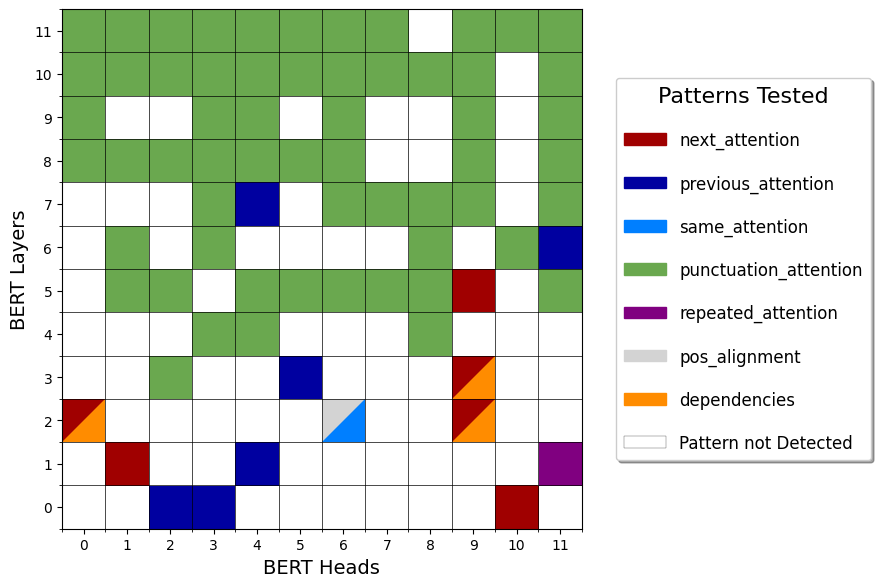

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALIZE BEST FIT PATTERNS ACROSS LAYERS AND HEADS

df = pd.read_csv('data/best_fit.csv')
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
mat = np.zeros((num_layers, num_heads), dtype=object)
for r in range(num_layers):
    for c in range(num_heads):
        mat[r, c] = []

for (i, j), group in df.groupby(['i', 'j']):
    sorted_group = group.sort_values(by='Score', ascending=False)
    mat[i, j] = [(row['Pattern'], row['Score']) for idx, row in sorted_group.iterrows()]

unique_patterns = df['Pattern'].unique()

dark_orange = '#FF8C00'
dark_blue = '#0000A0'
azure = '#007FFF'
medium_green = '#6aa84f'
gray = '#D3D3D3'
dark_red = '#A00000'
purple = '#800080'

hex_colors = [dark_red, dark_blue, azure, medium_green, purple, gray, dark_orange]
cmap_patterns = ListedColormap(hex_colors, name='my_cmap')

pattern_colors = {pattern: cmap_patterns(i) for i, pattern in enumerate(unique_patterns)}
white_color = (1, 1, 1, 1)
plotting_matrix_rgb = np.zeros((num_layers, num_heads, 3))

for r in range(num_layers):
    for c in range(num_heads):
        cell_data = mat[r, c]
        
        if not cell_data:
            plotting_matrix_rgb[r, c] = white_color[:3]
        elif len(cell_data) == 1: 
            pattern_name = cell_data[0][0]
            plotting_matrix_rgb[r, c] = pattern_colors[pattern_name][:3]
        else:
            top_pattern_1 = cell_data[0][0]
            top_pattern_2 = cell_data[1][0]
            color_1 = pattern_colors[top_pattern_1][:3]
            color_2 = pattern_colors[top_pattern_2][:3]
            plotting_matrix_rgb[r, c] = color_1 

custom_draw_mask = np.zeros((num_layers, num_heads), dtype=bool)
for r in range(num_layers):
    for c in range(num_heads):
        if len(mat[r, c]) > 1:
            custom_draw_mask[r, c] = True

fig, ax = plt.subplots(figsize=(9, 18))
img = ax.imshow(plotting_matrix_rgb, origin='lower', extent=[-0.5, num_heads - 0.5, -0.5, num_layers - 0.5])

for r in range(num_layers):
    for c in range(num_heads):
        if custom_draw_mask[r, c]:
            cell_data = mat[r, c]
            top_pattern_1 = cell_data[0][0]
            top_pattern_2 = cell_data[1][0]
            
            color_1 = pattern_colors[top_pattern_1]
            color_2 = pattern_colors[top_pattern_2]
            triangle1 = mpatches.Polygon(
                [[c - 0.5, r - 0.5], [c + 0.5, r - 0.5], [c + 0.5, r + 0.5]],
                facecolor=color_1, edgecolor='none'
            )
            ax.add_patch(triangle1)
            triangle2 = mpatches.Polygon(
                [[c - 0.5, r - 0.5], [c - 0.5, r + 0.5], [c + 0.5, r + 0.5]],
                facecolor=color_2, edgecolor='none'
            )
            ax.add_patch(triangle2)

ax.set_xticks(np.arange(num_heads))
ax.set_yticks(np.arange(num_layers))
ax.set_xticks(np.arange(-0.5, num_heads, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_layers, 1), minor=True)
ax.set_xlabel('BERT Heads', fontsize=14)
ax.set_ylabel('BERT Layers', fontsize=14)
# ax.set_title('Pattern Distribution Across Layers and Heads')
ax.set_aspect('equal')
# ax.grid(color='black', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

legend_handles = []
for pattern, color in pattern_colors.items():
    patch = mpatches.Patch(color=color, label=pattern)
    legend_handles.append(patch)

white_patch = mpatches.Patch(facecolor=white_color, label='Pattern not Detected', edgecolor='black', linewidth=0.2)
legend_handles.append(white_patch)
 
ax.legend(
    handles=legend_handles, 
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    ncol=1, 
    fancybox=True, 
    shadow=True, 
    title="Patterns Tested",
    title_fontsize=16,
    fontsize='large', # Make legend text bigger. Can use 'medium', 'x-large', 'xx-large' or a numerical value (e.g., 12)
    labelspacing=1.5, # Adjust vertical spacing between legend entries (default is 0.5)
    handlelength=2.5, # Adjust length of the color patch/line in the legend
    handletextpad=0.8, # Adjust space between the handle (color patch) and the text label
    borderpad=0.5 # Adjust padding between the legend content and its border
    
) 
plt.tight_layout()
plt.show()

plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make space for the legend
plt.show()

In [ ]:
# CONDUCT MODEL LEVEL ANALYSIS / GET SUMMARY SCORE FOR WHOLE MODEL

def classify_model(method, sentences, torch_model, torch_tokenizer):
    if method == "linear_fit":
        patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
    elif method == "best_fit":
        saved_file = pd.read_csv('data/best_fit_2.csv')

    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads

    all_scores = []
    final_scores = []
        
    for idx, sentence in enumerate(sentences):
        scores = np.zeros((num_layers, num_heads))
        for i in range(num_layers):
            for j in range(num_heads):
                layer, head = i, j
                inputs = torch_tokenizer(sentence, return_tensors="pt")
                len_seq = len(torch_tokenizer([sentence], return_tensors="pt").input_ids[0])

                X = []
                y =  torch_model(**inputs, output_attentions=True).attentions[layer][0, head].detach().numpy()

                if method == "linear_fit":
                    for pattern in patterns:
                        X.append(pattern(sentence, torch_tokenizer)[1].flatten())
                    X_n = np.array(X).T
                    y = y.flatten()

                    reg = LinearRegression().fit(X_n, y)
                    side_length = int(np.sqrt(len(y)))
                    y = y.reshape((side_length, side_length))

                    pred_att = reg.intercept_ + sum(coef * mat for coef, mat in zip(reg.coef_, X))
                    pred_att = pred_att.reshape((side_length, side_length))
                
                elif method == "best_fit":
                    matching_rows = saved_file[(saved_file['i'] == i) & (saved_file['j'] == j)]
                    if not matching_rows.empty:
                        best_pattern = matching_rows.loc[matching_rows['Score'].idxmax(), 'Pattern']
                        func = globals()[best_pattern]
                        _, pred_att = func(sentence, tokenizer)
                    else:
                        out = np.random.rand(len_seq, len_seq)
                        pred_att =  out / out.sum(axis=1, keepdims=True)

                elif method == "random_baseline":
                    # out = np.random.rand(len_seq, len_seq)
                    # pred_att =  out / out.sum(axis=1, keepdims=True)

                    pred_att = np.zeros((len_seq, len_seq))
                    pred_att[:, -1] = 1.0

                jensonshannon_distances = []
                for row_att, row_out in zip(y, pred_att):
                    jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
                score = np.mean(jensonshannon_distances)
                scores[layer, head] = score
                
        all_scores.append(scores)
        final_scores.append(np.sum(scores))
        print(f"Processed sentence #{idx}/{len(sentences)}: Score: {np.sum(scores):.2f}\n\t->'{sentence}'")

    print(f"Final Score: {sum(final_scores) / len(final_scores)}")
    return all_scores, final_scores

classify_model("random_baseline", sentences[:3], model, tokenizer)

<div style="text-align: center; font-size: 2em;">
  <hr>
    Program Automation Efforts
  <hr>
</div>

In [ ]:
# AUTOMATICALLY GENERATE PATTERNS FOR A HEAD & GENERATE LLM PROMPT

example_program_one = """
def dependencies(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]: /
    toks = tokenizer([sentence], return_tensors="pt") /
    len_seq = len(toks.input_ids[0]) /
    out = np.zeros((len_seq, len_seq)) /
    words = sentence.split() /
    doc = nlp(" ".join(words)) /
    for stok in doc: /
        parent_index = stok.i /
        for child_stok in stok.children: /
            child_index = child_stok.i /
            out[parent_index+1, child_index+1] = 1 /
            out[child_index+1, parent_index+1] = 1 /
    out[0, 0] = 1 /
    out[-1, 0] = 1 /
    out += 1e-4 /
    out = out / out.sum(axis=1, keepdims=True) /
    return "Dependency Parsing Pattern", out /
"""
example_program_two = """
def same_attention(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]: /
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    for i in range(1, len_seq-1):
        out[i, i] = 1
    out[0,0] = 1
    out[-1,0] = 1
    return "Same Token Pattern", out
"""
example_program_three = """
def pos_alignment(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt") /
    len_seq = len(toks.input_ids[0]) /
    out = np.zeros((len_seq, len_seq)) /
    # assign toks, input_ids, word_ids, len_seq, out, doc /
    # use spacey to get pos_tags for tokens in docs [token.pos_ for token in doc] /
    # for token in pos_tags: /
    # loop through pos_tags and increment out[i,j] when pos_tags match /
    # assign cls (out[0, 0] = 1) and eos (out[-1, 0] = 1) to have self_attention /
    # Normalize out matrix by row (results in uniform attention) and return out /
    # return 'Part of Speech Implementation 1', out /
"""

def generate_prompt(sentences, model, tokenizer, head_loc, top_k_ratio=0.1):
    layer, head = head_loc
    data = {
        "layer": layer,
        "head": head,
        "model": model.config.architectures[0],
        "examples": []
    }

    def handle_score(score):
        # convert to percentage with 0 decimal places
        return "{:.0f}".format(score * 100)
        
    def scrape_head(att, tokens, top_k_ratio, ignore_special=True):
        seq_len = att.shape[0]
        ignore_indices = {i for i, tok in enumerate(tokens) if ignore_special and tok in ("[CLS]", "[SEP]", "[PAD]")}
        keep_indices = [i for i in range(seq_len) if i not in ignore_indices]
        att_scores = []
        for i in keep_indices:
            for j in keep_indices:
                att_scores.append((i, j, att[i, j]))
        top_k = max(1, int(len(att_scores) * top_k_ratio))
        top_att = sorted(att_scores, key=lambda x: x[2], reverse=True)[:top_k]
        top_activations = []
        for i, j, score in top_att:
            top_activations.append(f"[{str(tokens[i])}|{str(tokens[j])}:{handle_score(score)}]")
        top_activations_str = " ".join(top_activations).replace("[", "").replace("]", "")
        return top_activations_str
    
    for idx, sentence in enumerate(sentences):
        inputs = tokenizer(sentence, return_tensors="pt")
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            att = outputs.attentions[layer][0, head]
        att = att.detach().cpu().numpy()
        top_activations = scrape_head(att, tokens, top_k_ratio=top_k_ratio)
        item = {f"sentence {idx}": " ".join(tokens), "sentence attention": top_activations}
        data["examples"].append(item)

    data = json.dumps(data, indent=2)
    prompt = f"""
    Using the following pieces of data based on {len(sentences)} sentences, generate three hypothesises about the linguistic role the following head is responsible for based on patterns
    in the activations.  Then, choose the most fitting hypothesis for the head function using examples from the data. Finally, using the linguistic hypothesis you determine, 
    write a python function which takes in a sentence and tokenizer as parameters and outputs the name of the pattern you hypothesize along with a predicted_matrix (size: token_len * token_len), which is the 
    rule encoded matrix mirroring attention patterns you'd predict for any given sentence for Layer {layer}, Head {head}. Feel free to encode complex functions but write the simplest algorithm that captures your 
    observed pattern. You must respond to this prompt in JSON in the form "{{"hypothesis": "...", "program": "..."}} with your chosen hypothesis. Think carefully before generating any code.
    The first portion of your response has key "hypothesis" with the title of the hypothesis and the second portion of your response with key "program" should have valid python code starting with ```python and including imports. These patterns can be simple or 
    complex.  For uniformity, the first three lines of your function should be 'toks = tokenizer([sentence], return_tensors="pt") len_seq = len(toks.input_ids[0]) out = np.zeros((len_seq, len_seq))'.
    Make sure the token sequences from your tokenizer and spaCy (if you must use spaCy) are aligned via a dictionary if necessary, because they split text differently. Make sure you generalize your hypothesis pattern to any sentence. Functions can almost 
    always be expressed in fewer than 50 lines of code. As examples, it has been discovered one head is responsible for the complex task of dependency parsing. It's simplistic predicted pseudocode looks like: 
    {example_program_one}. Example 2: '''{example_program_two}''' Example 3: '''{example_program_three}'''. DATA: {data}"""
    return ' '.join(prompt.strip().split())

model_name = "bert-base-uncased"
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

layer, head = 5, 7
prompt = generate_prompt(generic_sentences[:25], model, tokenizer, (layer, head), 0.025)
print(prompt)

In [225]:
# Using Gemini, GPT-4o, Claude, Deepseek
# API needs long contexts and free access
# Source to get API keys is "usage" key

load_dotenv()
API_CONFIGS = {
    "gemini": {
        "model": "gemini",
        "url": "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent",
        "key": os.getenv("GEMINI"),
        "headers_fn": lambda key: {"Content-Type": "application/json", "X-goog-api-key": key},
        "payload_fn": lambda prompt: {
            "contents": [{"parts": [{"text": prompt}]}],
            "generationConfig": {"response_mime_type": "application/json"}
        },
        "usage": "https://aistudio.google.com/apikey"
    },
    "openai": {
        "model": "openai",
        "url": "https://api.openai.com/v1/responses",
        "key": os.getenv("OPENAI"),
        "headers_fn": lambda key: {"Authorization": f"Bearer {key}", "Content-Type": "application/json"},
        "payload_fn": lambda prompt: {"model": "gpt-4.1", "input": prompt},
        "usage": "https://platform.openai.com/account/api-keys"
    },
    "claude": {
        "model": "claude",
        "url": "https://api.anthropic.com/v1/messages",
        "key": os.getenv("CLAUDE"),
        "headers_fn": lambda key: {"x-api-key": key, "Content-Type": "application/json", "Anthropic-Version":"2023-06-01"},
        "payload_fn": lambda prompt: {"model":"claude-sonnet-4-20250514", "messages":[{"role":"user","content":prompt}]},
        "usage": "https://platform.claude.com/api_keys"
    },
    "deepseek": {
        "model": "deepseek",
        "url": "https://api.deepseek.com/chat/completions",
        "key": os.getenv("DEEPSEEK"),
        "headers_fn": lambda key: {"Authorization": f"Bearer {key}", "Content-Type": "application/json"},
        "payload_fn": lambda prompt: {"model": "deepseek-chat", "input": prompt, "max_tokens": 1000},
        "usage": "https://platform.deepseek.com/api_keys"
    }
}

In [ ]:
# SAVE AUTOMATED HYPOTHESIS + VALIDATE GENERATED PROGRAM SYNTHESIS CODE

def parse_llm_idea(prompt, config="YOUR_API_CONFIG", verbalize=True):
    def make_request():
        headers = config["headers_fn"](config["key"])
        payload = config["payload_fn"](prompt)
        response = requests.post(config["url"], headers=headers, data=json.dumps(payload))
        response.raise_for_status()

        if config["model"] == "gemini":
            data = response.json()
            output = data["candidates"][0]["content"]["parts"][0]["text"]
        if config["model"] == "openai":
            pass
        if config["model"] == "claude":
            data = response.json()
            output = data["content"]["text"]
        if config["model"] == "deepseek":
            pass

        return output
    
    output = make_request()

    try:
        result = json.loads(output)

        if type(result) is list: result = result[0]
        hypothesis = result.get("hypothesis", "")
        program = result.get("program", "")

        if program.startswith("```python"): program = program[9:]
        if program.endswith("```"): program = program[:-3]
        program = program.strip()

        if verbalize: print("Hypothesis, Explanation & Program successfully parsed")

    except Exception as e:
        print(f"Parsing API failed: {str(e)}")
        return str(e)

    return hypothesis, program

config = API_CONFIGS["gemini"] 
parse_llm_idea(prompt, config=config, verbalize=True)

In [ ]:
# SIMPLE AUTOMATION OF PIPELINE FOR ANALYZING ALL HEADS & WRITING/SAVING PROGRAMS

def automation_pipeline(model, tokenizer, sentences, API_KEY, save_data=True, evaluate=False):
    heads = model.config.num_attention_heads
    layers = model.config.num_hidden_layers
    prompts, programs = [], []

    for layer in range(layers):
        # if layer == 0: continue
        if save_data:
            # save prompts:
            prompt_path = f"automation_2/prompts/{layer}/"
            os.makedirs(prompt_path, exist_ok=True)

            # save programs:
            program_path = f"automation_2/llm_code/code_layer_{layer}/"
            os.makedirs(program_path, exist_ok=True)

            # save scores:
            if evaluate:
                score_path = f"automation_2/scores/{layer}/"
                os.makedirs(score_path, exist_ok=True)

        for head in range(heads):
            # if head < 9: continue
            if (layer, head) not in failed_programs:
                continue
            prompt = generate_prompt(sentences, model, tokenizer, (layer, head), top_k_ratio=0.1)
            hypothesis, explanation, program = parse_llm_idea(prompt, API_KEY, output=False)
            print(f"Analyzed Layer {layer}, Head {head} | Hypothesis ~ {hypothesis} ")

            prompts.append(prompt)
            programs.append(program)

            if save_data:
                with open(f"{prompt_path}/{layer}_{head}_prompt.txt", "w") as f: f.write(prompt)
                with open(f"{program_path}/{head}_output.py", "w") as f: f.write(program)

        if evaluate: 
            pass

    return None

automation_pipeline(model, tokenizer, generic_sentences[:10], API_KEY=API_KEY, save_data=True, evaluate=False)

In [ ]:
import importlib.util
import types

def validate_program(program_path, model, tokenizer, layer, head, sentences):       
    try:
        spec = importlib.util.spec_from_file_location("loaded_program", program_path)
        module = importlib.util.module_from_spec(spec)
        module.__dict__['np'] = np
        spec.loader.exec_module(module)
    except Exception as e:
        print(f"Program loading failed: {str(e)}")
        return str(e)

    for attr_name in dir(module):
        attr = getattr(module, attr_name)
        if isinstance(attr, types.FunctionType):
            program = attr
            break

    # try:
    score = score_prediction(model, tokenizer, (layer, head), program, sentences, distance="jsd", output=True)
    return score
    # except Exception as e:
    #     print(f"Program validation failed: {str(e)}")
    #     return str(e)

python_path = r"automation_results_gemini\llm_code\programs-layer_0\0_output.py"
feedback = validate_program(python_path, model, tokenizer, layer, head, sentences)

In [130]:
# CALCULATE AND SAVE SCORES FOR AUTOMATICALLY GENERATED PROGRAMS

import importlib.util
import types

scores = []
failed_programs = []
for layer in range(12):
    # if layer != 11: continue
    code_path = f"automation_2/llm_code/code_layer_{layer}/"
    for j in range(12):
        # if j != 11: continue
        filename = f"{j}_output.py"
        program_path = os.path.join(code_path, filename)
        if not os.path.exists(program_path): continue
        score_path = f"automation_2/scores/{layer}_{j}_score.txt"
        os.makedirs(os.path.dirname(score_path), exist_ok=True)

        try:
            spec = importlib.util.spec_from_file_location(f"layer{layer}_j{j}", program_path)
            module = importlib.util.module_from_spec(spec)
            module.__dict__['np'] = np
            spec.loader.exec_module(module)
        except Exception as e:
            print(f"Layer {layer}, Head {j} - Error: {e}")
            with open(score_path, "w") as f: f.write(f"Error loading module: {e}")
            failed_programs.append((layer, j))
            scores.append(-1)
            continue

        for attr_name in dir(module):
            attr = getattr(module, attr_name)
            if isinstance(attr, types.FunctionType):
                program = attr
                break

        try:
            score = score_prediction(model, tokenizer, (layer, j), program, generic_sentences[0], distance="jsd", output=False)
            print(f"Layer {layer}, Head {j} - Score: {score:.2f}")
            with open(score_path, "w") as f: f.write(f"{score:.2f}")
            scores.append(score)
        except Exception as e:
            print(f"Layer {layer}, Head {j} - Error: {e}")
            with open(score_path, "w") as f: f.write(f"Error during scoring: {e}")
            failed_programs.append((layer, j))
            scores.append(-1)
            continue

num_scored = len([s for s in scores if s != -1 and not np.isnan(s)])
print(f"Number of Successfully Scored Heads: {num_scored} out of {len(scores)}")

avg_score = sum([s for s in scores if s != -1 and not np.isnan(s)]) / len([s for s in scores if s != -1 and not np.isnan(s)])
print(f"Average Score (excluding errors): {avg_score:.2f}")

Layer 0, Head 0 - Score: 0.39
Layer 0, Head 1 - Score: 0.64
Layer 0, Head 2 - Score: 0.72
Layer 0, Head 3 - Score: 0.60
Layer 0, Head 4 - Score: 0.24
Layer 0, Head 5 - Score: 0.73
Layer 0, Head 6 - Score: 0.37
Layer 0, Head 7 - Score: 0.41


c:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_2/llm_code/code_layer_0/8_output.py:57: RuntimeWarning: invalid value encountered in divide
  out = out / row_sums[:, np.newaxis]


Layer 0, Head 8 - Score: nan
Layer 0, Head 9 - Score: 0.57
Layer 0, Head 10 - Score: 0.64
Layer 0, Head 11 - Score: 0.69
Layer 1, Head 0 - Score: 0.58
Layer 1, Head 1 - Score: 0.59
Layer 1, Head 2 - Score: 0.68
Layer 1, Head 3 - Score: 0.57
Layer 1, Head 4 - Score: 0.74
Layer 1, Head 5 - Error: list index out of range
Layer 1, Head 6 - Score: 0.72
Layer 1, Head 7 - Score: 0.39
Layer 1, Head 8 - Score: 0.63
Layer 1, Head 9 - Score: 0.40
Layer 1, Head 10 - Score: 0.63
Layer 1, Head 11 - Score: 0.65
Layer 2, Head 0 - Score: 0.75
Layer 2, Head 1 - Score: 0.67
Layer 2, Head 2 - Score: 0.62
Layer 2, Head 3 - Score: 0.77
Layer 2, Head 4 - Score: 0.47
Layer 2, Head 5 - Score: 0.57
Layer 2, Head 6 - Score: 0.63
Layer 2, Head 7 - Score: 0.51
Layer 2, Head 8 - Score: 0.57
Layer 2, Head 9 - Score: 0.45
Layer 2, Head 10 - Score: 0.52
Layer 2, Head 11 - Score: 0.45
Layer 3, Head 0 - Score: 0.67
Layer 3, Head 1 - Score: 0.54
Layer 3, Head 2 - Score: 0.58
Layer 3, Head 3 - Score: 0.57
Layer 3, Head 4 

c:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_2/llm_code/code_layer_8/7_output.py:17: RuntimeWarning: invalid value encountered in divide
  out = (out.T / np.sum(out, axis=1)).T


Layer 8, Head 7 - Score: nan
Layer 8, Head 8 - Score: 0.67
Layer 8, Head 9 - Score: 0.60
Layer 8, Head 10 - Score: 0.59
Layer 8, Head 11 - Score: 0.63
Layer 9, Head 0 - Error: list index out of range
Layer 9, Head 1 - Score: 0.70
Layer 9, Head 2 - Error: list index out of range
Layer 9, Head 3 - Score: 0.74
Layer 9, Head 4 - Score: 0.70
Layer 9, Head 5 - Error: list index out of range
Layer 9, Head 6 - Score: 0.70
Layer 9, Head 7 - Score: 0.79
Layer 9, Head 8 - Error: unexpected character after line continuation character (automation_2/llm_code/code_layer_9/8_output.py, line 42)
Layer 9, Head 9 - Score: 0.67
Layer 9, Head 10 - Error: 'NoneType' object is not subscriptable
Layer 9, Head 11 - Score: 0.67
Layer 10, Head 0 - Score: 0.77
Layer 10, Head 1 - Score: 0.82
Layer 10, Head 2 - Score: 0.79
Layer 10, Head 3 - Score: 0.59
Layer 10, Head 4 - Score: 0.76
Layer 10, Head 5 - Score: 0.82
Layer 10, Head 6 - Score: 0.79
Layer 10, Head 7 - Score: 0.77
Layer 10, Head 8 - Score: 0.57
Layer 10,

C:\Users\amkah\AppData\Local\Temp\ipykernel_29268\470081021.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colors).copy()


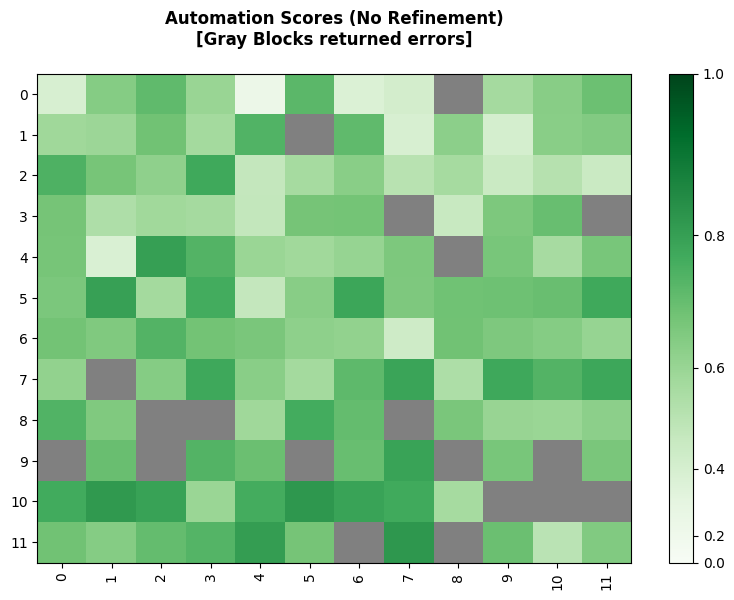

In [156]:
colors = "Greens"
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
masked_sq = np.ma.masked_where(sq_score == -1, sq_score)
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')
im2 = ax.imshow(masked_sq, cmap=cmap, aspect='auto', norm=norm)
im2.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im2, ax=ax)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels([i for i in range(12)], rotation=90)
ax.set_yticklabels([i for i in range(12)])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("Automation Scores (No Refinement)\n[Gray Blocks returned errors]\n", weight='bold')
plt.show()

<div style="text-align: center; font-size: 2em;">
  <hr>
    Hypothesis Structure Experiments
  <hr>
</div>

In [ ]:
import networkx as nx
from programs import *

programs = [next_attention, previous_attention, same_attention, punctuation_attention, dependencies,
            last_token_attention, uniform_attention, cls_attention, eos_attention, pos_alignment,
            special_token_attention, repeated_attention, noun_modifier_attention, pronoun_attention,
            single_token_attention, root_cluster_attention]

sentence_data = sentences[:25]
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def program_similarity(att_one, att_two):
    def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
        p = np.clip(p, 1e-12, 1.0)
        q = np.clip(q, 1e-12, 1.0)
        p /= p.sum()
        q /= q.sum()
        m = 0.5 * (p + q)
        return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m))) 

    jensonshannon_distances = []
    for row_att, row_out in zip(att_one, att_two):
        jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
    score = np.mean(jensonshannon_distances)
    return score

x = len(programs)
S = np.zeros((x, x))
for i in range(x):
    print(f"calculating hypothesis similarities [{i}]: {programs[i].__name__}")
    for j in range(x):
        if i != j:
            similarities = []
            program_one = programs[i]
            program_two = programs[j]

            for sentence in sentence_data:
                h1, activations_one = program_one(sentence, tokenizer)
                h2, activations_two = program_two(sentence, tokenizer)
                similarities.append(program_similarity(activations_one, activations_two))
            
            S[i, j] = np.mean(similarities)

In [67]:
S

array([[0.        , 0.72248264, 0.72248264, 0.7347226 , 0.51406976,
        0.78389433, 0.75489314, 0.72248264, 0.77751862, 0.7590144 ,
        0.72885834, 0.72248264, 0.6555284 , 0.6555284 , 0.80065486,
        0.74567313],
       [0.72248264, 0.        , 0.72248264, 0.8322484 , 0.58349394,
        0.83255461, 0.75489314, 0.66744665, 0.83255461, 0.7590144 ,
        0.78389433, 0.72248264, 0.6555284 , 0.6555284 , 0.77751862,
        0.79048112],
       [0.72248264, 0.72248264, 0.        , 0.8322484 , 0.72162638,
        0.80822447, 0.75489314, 0.72248264, 0.83255461, 0.35187654,
        0.78389433, 0.03426661, 0.6555284 , 0.6555284 , 0.77751862,
        0.81481126],
       [0.7347226 , 0.8322484 , 0.8322484 , 0.        , 0.8112586 ,
        0.20738833, 0.6822155 , 0.8322484 , 0.4474114 , 0.75834177,
        0.4819473 , 0.8310659 , 0.70069961, 0.70069961, 0.82976148,
        0.47560356],
       [0.51406976, 0.58349394, 0.72162638, 0.8112586 , 0.        ,
        0.8223732 ,        nan, 

In [79]:
def group_similar_programs(programs, S, threshold=0.6):
    groups, used = [], set()
    for i in range(len(programs)):
        if i in used: continue
        group = [i]
        used.add(i)
        
        changed = True
        while changed:
            changed = False
            for group_member in group:
                for j in range(len(programs)):
                    if j not in used and S[group_member, j] < threshold:
                        group.append(j)
                        used.add(j)
                        changed = True
        groups.append([programs[idx].__name__ for idx in group])
    
    return groups

groups = group_similar_programs(programs, S, threshold=0.6)
for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}")

Group 1: ['next_attention', 'dependencies', 'previous_attention']
Group 2: ['same_attention', 'pos_alignment', 'repeated_attention']
Group 3: ['punctuation_attention', 'last_token_attention', 'eos_attention', 'special_token_attention', 'root_cluster_attention']
Group 4: ['uniform_attention']
Group 5: ['cls_attention']
Group 6: ['noun_modifier_attention', 'pronoun_attention']
Group 7: ['single_token_attention']


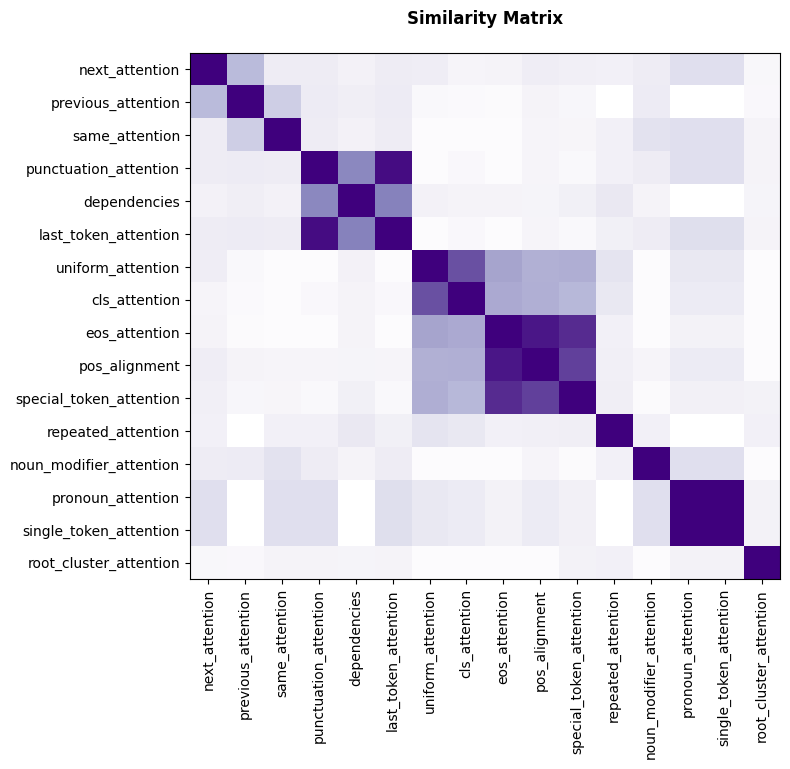

In [78]:
name_to_idx = {fn.__name__: i for i, fn in enumerate(programs)}
new_order = [name_to_idx[name] for group in groups for name in group]
S_grouped = S[np.ix_(new_order, new_order)]
colors = "Purples_r"
fig, ax = plt.subplots(1, 1, figsize=(8,8))
im2 = ax.imshow(S_grouped, cmap=colors, aspect='auto')
# ax.set_axis_off()
ax.set_xticks(range(len(programs)))
ax.set_yticks(range(len(programs)))
ax.set_xticklabels([p.__name__ for p in programs], rotation=90)
ax.set_yticklabels([p.__name__ for p in programs])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("Similarity Matrix\n", weight='bold')
plt.show()